In [1]:
import utils
import r_pca

import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [44]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

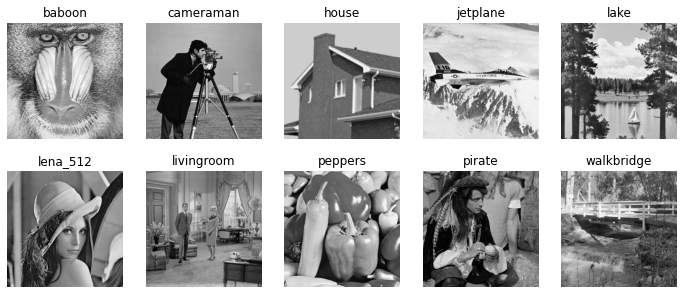

In [45]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [46]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])

In [47]:
dataset.shape

(10, 512, 512)

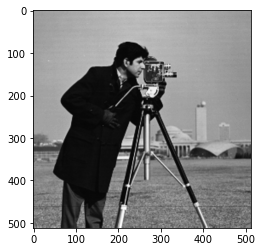

In [48]:
plt.imshow(dataset[1], cmap='gray')

In [60]:
d = 9
matrix_modes = [2] * d
original = dataset[1]
#original = original / 255.

vector, vector_modes = utils.matrix_to_vector(original, d, matrix_modes)

In [61]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    vector,
    d,
    vector_modes,
    lambda_scale=2.5,
    max_iter=100
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4
Current step 5
Current step 6
Current step 7
Current step 8


In [62]:
ranks

[4, 16, 64, 256, 256, 64, 16, 4]

In [63]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

In [64]:
print(np.sum(np.isclose(original, low_rank_matrix)), original.size)

220882 262144


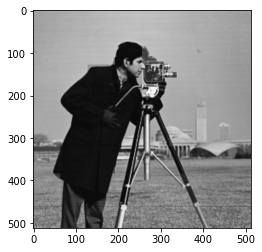

In [65]:
plt.imshow(low_rank_matrix, cmap='gray')

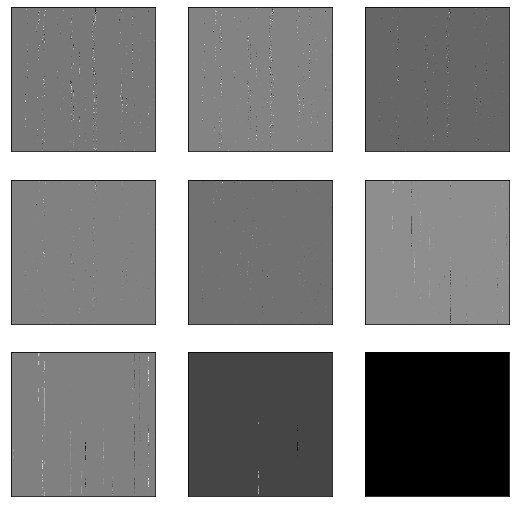

In [66]:
n = 2 ** d

fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        sparse_parts[i].toarray().reshape((n, n), order='F'),
        #sparse_parts[i].toarray(),
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])

In [79]:
sparse_combined = np.sum([s.toarray().reshape((n, n), order='F') for s in sparse_parts], axis=0)
sum_1 = low_rank_matrix + sparse_combined
sum_2 = utils.add_sparse_parts(low_rank_part, d, vector_modes, sparse_parts)
sum_2, _ = utils.vector_to_matrix(sum_2, d, vector_modes)

np.max(np.abs(sum_1 - sum_2))
#способы существенно разные

109.02235225796984

In [80]:
print(np.linalg.norm(original - sum_1) / np.linalg.norm(original))
print(np.linalg.norm(original - sum_2) / np.linalg.norm(original))

0.04789346356869589
1.706569864976809e-06


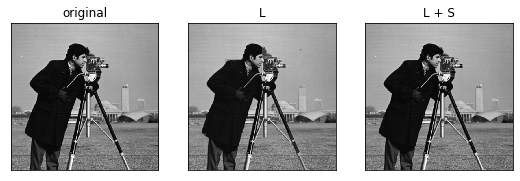

In [81]:
fig = plt.figure(figsize=(9, 3))
data_to_show = [original, low_rank_matrix, sum_2]
data_labels = ['original', 'L', 'L + S']
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Попробуем потестировать на salt-and-pepper noise, что ли...

In [96]:
#https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
#вообще, наверное, есть более-менее строгое определение, но я его не нашёл

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

$$p \in [0,1/2] \Rightarrow \hat{A}_{ij} = \begin{cases}
0 &\text{с вероятностью $p$} \\
255 &\text{с вероятностью $p$} \\
A_{ij} &\text{с вероятностью $1 - 2p$} \\
\end{cases}$$
Броски независимые для разных $i,j$.

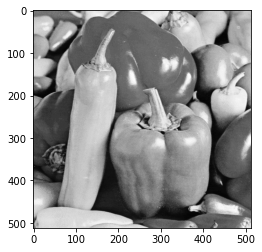

In [129]:
original = dataset[7]
plt.imshow(original, cmap='gray')

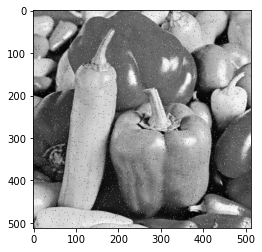

In [130]:
noisy = sp_noise(original, 0.01)
plt.imshow(noisy, cmap='gray')

Пошёл пайплайн:

In [132]:
vector, vector_modes = utils.matrix_to_vector(noisy, d, matrix_modes)
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    vector,
    d,
    vector_modes,
    lambda_scale=2.,
    max_iter=200
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4
Current step 5
Current step 6
Current step 7
Current step 8


In [133]:
ranks

[4, 16, 64, 256, 256, 64, 16, 4]

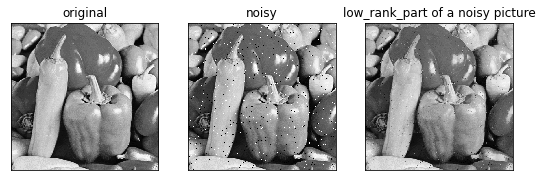

In [134]:
low_rank_matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

fig = plt.figure(figsize=(9, 3))
data_to_show = [original, noisy, low_rank_matrix]
data_labels = ['original', 'noisy', 'low_rank_part of a noisy picture']
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(
        data_to_show[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])
plt.show()

Как надо складывать разреженные части:

In [135]:
s2 = []
for s in sparse_parts:
    tmp = s.toarray().flatten(order='f')
    tmp, _ = utils.vector_to_matrix(tmp, d, vector_modes)
    s2.append(tmp.reshape((n, n), order='F'))

In [136]:
sparse_combined = np.sum(s2, axis=0)
sum_2 = utils.add_sparse_parts(low_rank_part, d, vector_modes, sparse_parts)
sum_2, _ = utils.vector_to_matrix(sum_2, d, vector_modes)
print(np.linalg.norm(sparse_combined + low_rank_matrix - sum_2))

4.664565500987171e-13


Нарисуем их теперь:

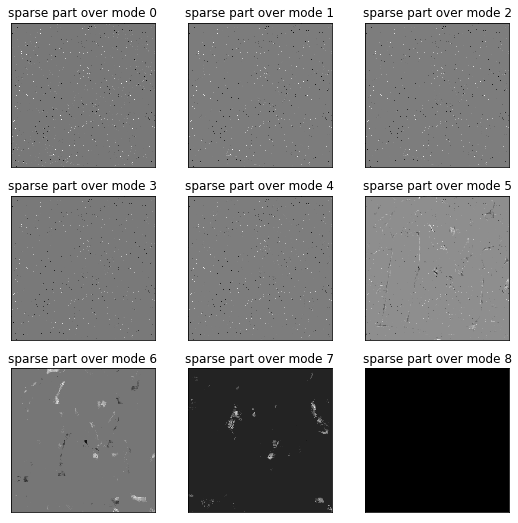

In [137]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(
        s2[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("sparse part over mode " + str(i))
plt.show()

Правда ли, что low_rank_part ближе к оригинальному изображению, нежели к шуму? 

In [139]:
print(np.linalg.norm(low_rank_matrix - noisy) / np.linalg.norm(original))
print(np.linalg.norm(low_rank_matrix - original) / np.linalg.norm(original))

0.10446393418261316
0.0722212101100446


Ненамного, но да, ближе.